In [1]:
import sys
import os
import logging
from IPython.display import clear_output
sys.path.append('../src')

# local imports.
from utils import ROOT_DIR
from data_loader import FarsightDataset, ToTensor
import visualize as viz
import model
from utils import DATA_DIR, get_depth_dir, get_img_dir, get_dev
from other_models.tiny_unet import UNet



import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
# task = Task.init(project_name='mde', task_name='test loop')
# logger = task.get_logger()

import matplotlib.pyplot as plt
from trains import Task
from tqdm import tqdm


%load_ext autoreload
%autoreload 2

In [14]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        print(m.weight.data)
#         torch.nn.init.normal_(m.weight.data)

In [17]:

def train(epochs=2,
          verbose=False,
          batch_size=2,
          val_percent=0.25):
    """
    main training loop.
    """
    print('started')
    writer = SummaryWriter()
    # create dataset
    ds = FarsightDataset(img_dir=get_img_dir(),
                         depth_dir=get_depth_dir(),
                         transform=ToTensor())
    mini_ds = Subset(ds, range(2))
    n_val = int(len(mini_ds) * val_percent)
    n_train = len(mini_ds) - n_val
    train, val = random_split(mini_ds,
                              [n_train, n_val],
                              generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(mini_ds,
                              shuffle=False,
                              batch_size=batch_size,
                              num_workers=0)
#     val_loader = DataLoader(val,
#                             shuffle=False,
#                             batch_size=batch_size,
#                             num_workers=0)
    # TODO: fix weird float32 requirement in conv2d to work with uint8. Quantization?
    net = UNet()
    net.to(device=get_dev())
    print('using ', get_dev())
#     net.apply(weight_init)
    num_batches = len(train_loader)
    print('num_batches: ', num_batches)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters())
    # main training loop.
    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [input images, depth maps]
                imgs, gt_depths = data['image'], data['depth']
                optimizer.zero_grad()
                # print('input shape {}, type: {}'.format(inputs.size(), inputs.dtype))
                pred_depth = net(imgs)
                #             print('out shape: {}, gt shape: {}'.format(outputs.size(), gt_depths.size()))
                loss = criterion(pred_depth, gt_depths)
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                pbar.update(imgs.shape[0])
                # val statistics. check stats
#                 if i == num_batches - 1:  # last batch
                if epoch % 10 == 0:
                    print(running_loss / num_batches)
                    writer.add_scalar('Loss/train', running_loss / num_batches, epoch + 1)
#                     print(running_loss /)
                    # val scores
#                     val_score = model.eval_net(net, val_loader, criterion, writer)
#                     writer.add_scalar('Metric/test', val_score, epoch)
#                     logging.info('Validation score (metric?): {}'.format(val_score))

                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), epoch)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), epoch)
                    writer.add_histogram('values', pred_depth.detach().cpu().numpy(),epoch)
                    fig = viz.show_batch({**data, 'pred': pred_depth.detach()})
                    fig.suptitle(f'epoch {epoch}', fontsize='xx-large')
#                     plt.show()
#                     plt.title(f'epoch {epoch}')
                    print('adding plot')
                    writer.add_figure(tag='epoch/end', figure=fig, global_step=epoch)
                    writer.add_images('images', imgs, epoch)
                    writer.add_images('masks/true', gt_depths.unsqueeze(1), epoch)
                    writer.add_images('masks/pred', pred_depth.unsqueeze(1), epoch)
#             if verbose or epoch == epochs - 1:
                #             viz.show_batch({**data, 'pred': outputs.detach()})
#                 plt.show()
    print('Finished Training')
    writer.close()
    return gt_depths, pred_depth

In [18]:
gt, pred = train(50)

Epoch 1/50: 100%|██████████| 2/2 [00:00<00:00, 12.21img/s, loss (batch)=0.19]

started
using  cuda
num_batches:  1
0.18968874216079712
batch size:  2
adding plot


Epoch 11/50: 100%|██████████| 2/2 [00:00<00:00, 11.34img/s, loss (batch)=0.0586]

0.05860472470521927
batch size:  2
adding plot


Epoch 21/50: 100%|██████████| 2/2 [00:00<00:00, 11.80img/s, loss (batch)=0.0414]

0.04139445349574089
batch size:  2
adding plot


Epoch 29/50:   0%|          | 0/2 [00:00<?, ?img/s]


KeyboardInterrupt: 

batch size:  2


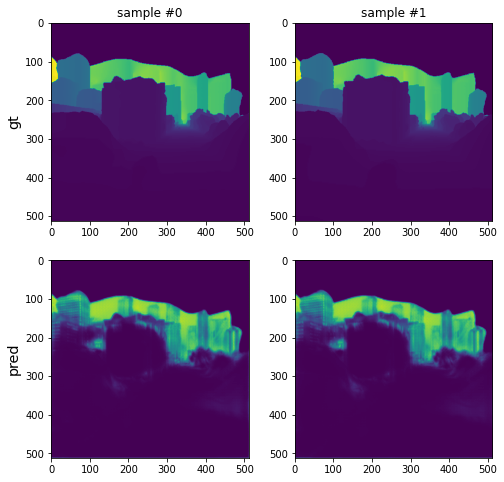

In [13]:
viz.show_batch({'gt':gt,'pred':pred})
plt.show()